In [1]:
import glob
import math
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as ski
import re

from pathlib import Path
cur_dir = Path().resolve()
sys.path.append(str(cur_dir) + "/module")

#### グラフの線種を決定するジェネレータ

In [2]:
def linestyle_generator():
    linestyle = ['-', '--', '-', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

#### 画像表示用

In [3]:
def imshow_set(fig_ax, *args):
    fig_ax.set_title(args[0])
    fig_ax.imshow(args[1])

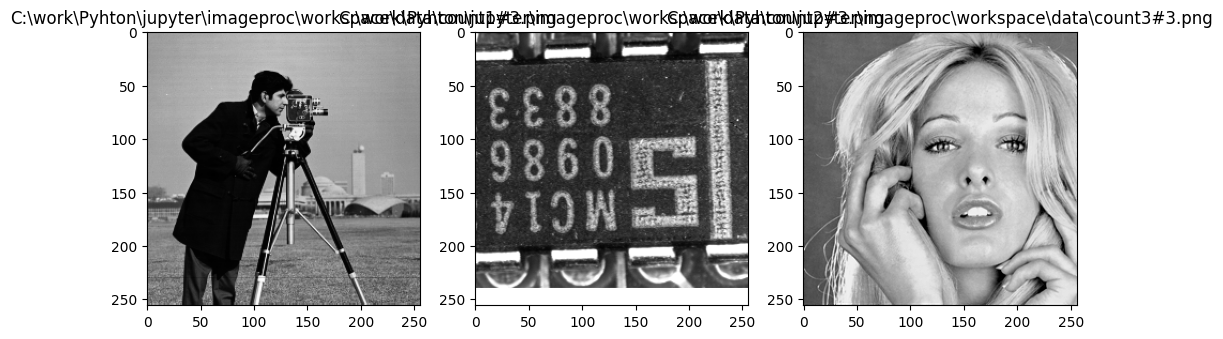

In [11]:
# Get Image file paths
path_list = glob.glob(r'C:\work\Pyhton\jupyter\imageproc\workspace\data\count*#3.png')
img_list = [cv2.imread(path, -1) for path in path_list]

fig, ax = plt.subplots(1, len(img_list), figsize=(12, 5))
for img, a, p in zip(img_list, ax, path_list):
    a.set_title(str(p))
    a.imshow(img, cmap='gray')




In [13]:
# Calculate mean brightness of each image
mean_intensity_list = [np.mean(img) for img in img_list]
print(mean_intensity_list)

# Calculate target intensity 

118.7244873046875

In [ ]:
# lineprofile
# x direction

# y direction

In [ ]:
# 8ビット1チャンネルのグレースケールとして画像を読み込む
img = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE) 

# 白黒反転して二値化
ret, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

# 一番外側の輪郭のみを取得
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE ) 

# 画像表示用に入力画像をカラーデータに変換する
img_disp = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# 全ての輪郭を描画
cv2.drawContours(img_disp, contours, -1, (0, 0, 255), 2)

# 輪郭の点の描画
for contour in contours:
    # 円近似
    center, r = fitCircle(contour)
    # 近似円を描画
    cv2.circle(img_disp, np.intp(center), int(r), (255, 0, 0), 2)

cv2.imshow("Image", img_disp)

# キー入力待ち(ここで画像が表示される)
cv2.waitKey()